(example_2)=
# Non-parametric predictive coding using Dirichlet process nodes

In [2]:
from functools import partial
from typing import Dict, Tuple

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import HTML, display
from jax import config, jit
from jax.scipy.stats.norm import logpdf
from matplotlib.animation import FuncAnimation
from pyhgf.math import gaussian_surprise
from pyhgf.model import HGF
from pyhgf.networks import add_edges, concatenate_networks
from pyhgf.typing import Edges, InputIndexes
from scipy.optimize import minimize
from scipy.stats import multinomial, norm

config.update("jax_disable_jit", True)

PyHGF is built on a modular framework that allows working with programmatically pure functions, which means that the structure of the network, as well as the update steps connecting the nodes, are parameters of the belief propagation functions. Most applications of predictive coding neural networks are mostly concerned with the update of the attributes of the network during inference. However, one consequence of this parametrisation is that networks can change their structure during the belief propagation, for example as a function of the prediction errors elicited by the observation. This concept is often referred to as a self-organizing neural network (see for example {cite:p}`Najarro:2023`).

Having a network that can change shape as a function of incoming observations can be a powerful tool if we do not want to parametrise too rigidly our model beforehand, but instead want to let its complexity grow infinitely as observations grow infinitely, a property that is central for nonparametric Bayesian modelling {cite:p}`Gershman2012`. In this notebook, we illustrate how this idea can be applied to create a network that can grow and remove branches and approximates the evolution of a [Dirichlet process](https://en.wikipedia.org/wiki/Dirichlet_process).

## Example 1: Clustering observations from a Gaussian mixture
### Create the dataset

In [2]:
np.random.seed(123)

# simulate a dataset
n_trials = 100


def get_value():
    cat = multinomial(n=1, p=[0.2, 0.2, 0.6]).rvs()
    vals = np.random.normal([0, 20, 40], 1)
    return (cat * vals).sum()


input_data = []
for i in range(n_trials):
    input_data.append(get_value())

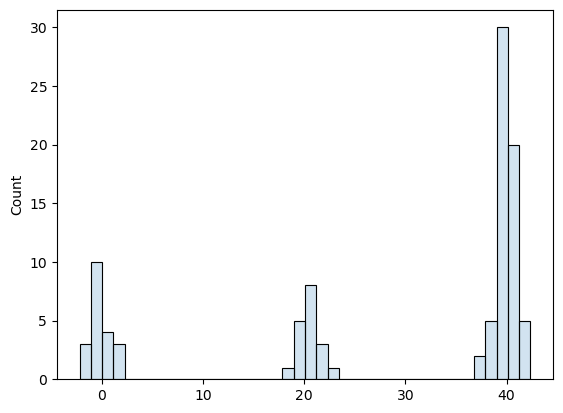

In [3]:
sns.histplot(x=input_data, alpha=0.2, bins=40);

### Create the Dirichlet process node
#### The base branch

The first component required by the Dirichlet process node is the base branch. This network has a role similar to the base distribution in the Dirichlet process and should encode the structure of the branch that is duplicated. Here, we start with a simple one-level continuous HGF with both a volatility and value parent. This network will try to learn the mean precision of a latent variable (see also {ref)`Example_2_Input_node_volatility_coupling`).

In [4]:
# create the Dirichlet node structure
base_network = (
    HGF(model_type=None)
    .add_nodes(
        kind="continuous-input",
        node_parameters={"input_noise": 1.0, "expected_precision": 1.0},
    )
    .add_nodes(
        value_children=0, node_parameters={"tonic_volatility": -2.0, "precision": 0.5}
    )
    .add_nodes(volatility_children=0)
).set_update_sequence()

Initializing a network with custom node structure.


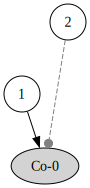

In [5]:
base_network.plot_network()

#### The likelihood function
The second component is the likelihood function of the base network. This function will be used by every branch of the Dirichlet node to compare the likelihood of every new observation. This function should point to the input node(s) of the given branch. Here, the likelihood is simply the Gaussian likelihood given the mean and precision of the underlying distribution.

In [6]:
def log_likelihood_fn(input_idx, value, attributes, edges):
    value_parent_idx = edges[input_idx].value_parents[0]
    logp = -gaussian_surprise(
        x=value,
        expected_mean=attributes[value_parent_idx]["mean"],
        expected_precision=attributes[input_idx]["expected_precision"],
    )

    return logp

#### The branching function
Finally, the third component of the Dirichlet node is the branching function. This function generates a new branch if no other branch can better explain the new incoming observation. Creating a new branch is a two-step process:
1. Creating the network structure.
2. Parametrizing the attribute of the network.
The first step is straightforward and mainly requires merging a new *base branch* in the network. The second step should decide which priors to use for the new branch, which involves non-trivial arbitrary decisions as - by definition - this new branch has only observed one data point so far.

#### The Dirichlet process node
Finally, we define the main network with a Dirichlet process as the input node. This input takes the base branch as a template to duplicate later.

In [7]:
# create the Dirichlet node structure
dirichlet_hgf = HGF(model_type=None).add_nodes(
    kind="dirichlet-input",
    node_parameters={
        "alpha": 0.5,
        "base_network": base_network,
        "log_likelihood_fn": log_likelihood_fn,
    },
)

Initializing a network with custom node structure.


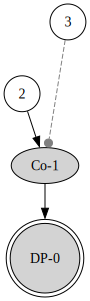

In [8]:
dirichlet_hgf.plot_network()

In [9]:
dirichlet_hgf.set_update_sequence();

### Add observations to the network

In [10]:
for value in input_data[:10]:
    for node_idx, update_fn in dirichlet_hgf.update_sequence:
        if "dirichlet" in update_fn.__name__:
            attributes = dirichlet_hgf.attributes
            edges = dirichlet_hgf.edges
            dirichlet_node = dirichlet_hgf.dirichlet_node
            input_nodes_idx = dirichlet_hgf.input_nodes_idx

            attributes, edges, input_nodes_idx, dirichlet_node = update_fn(
                edges=edges,
                attributes=attributes,
                value=value,
                time_step=1.0,
                node_idx=node_idx,
                dirichlet_node=dirichlet_node,
                input_nodes_idx=input_nodes_idx,
            )

            dirichlet_hgf.attributes = attributes
            dirichlet_hgf.edges = edges
            dirichlet_hgf.input_nodes_idx = input_nodes_idx
            dirichlet_hgf.dirichlet_node = dirichlet_node

            dirichlet_hgf.set_update_sequence()

        else:
            attributes = dirichlet_hgf.attributes
            edges = dirichlet_hgf.edges

            attributes = update_fn(
                attributes=attributes,
                time_step=1.0,
                node_idx=node_idx,
                edges=edges,
                value=value,
                observed=1.0,
            )

            dirichlet_hgf.attributes = attributes

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Step 1 - 1.0
Creating new branch.
Step 1 - 0.3678794503211975
Step 2 - 0.3678794503211975
Step 2.1 - 0.3678794503211975
Step 2.2 - 0.3678794503211975
Step 3 - 0.3678794503211975
Creating new branch.
Step 1 - 0.42085811495780945
Step 2 - 0.42085811495780945
Step 2.1 - 0.42085811495780945
Step 2.2 - 0.42085811495780945
Step 3 - 0.42085811495780945
Creating new branch.
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Updating branch 7
Step 1 - 0.0
Step 2 - 0.0
Step 2.1 - 0.0
Step 2.2 - 0.0
Step 3 - 0.0
Creating new branch.


## Plotting results

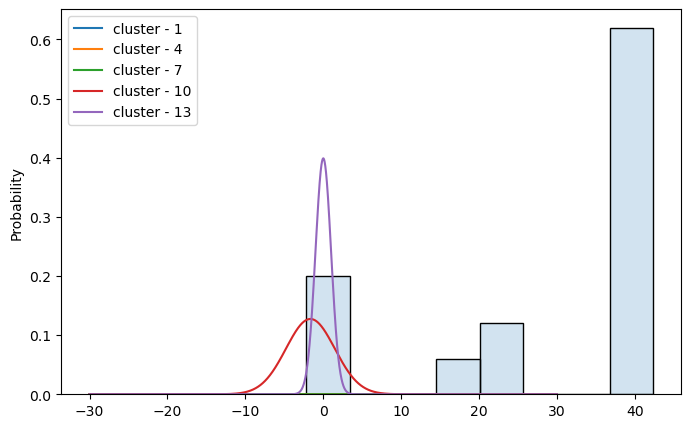

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
for input_idx in dirichlet_hgf.dirichlet_node.cluster_input_idxs:
    value_parent_idx = dirichlet_hgf.edges[input_idx].value_parents[0]
    volatility_parent_idx = dirichlet_hgf.edges[input_idx].volatility_parents[0]

    mean = dirichlet_hgf.attributes[value_parent_idx]["expected_mean"]

    # the precision of the Gaussian is given by:
    precision = attributes[input_idx]["expected_precision"]

    ax.plot(
        np.arange(-30, 30, 0.01),
        norm(loc=mean, scale=np.sqrt(1 / precision)).pdf(np.arange(-30, 30, 0.01)),
        label=f"cluster - {input_idx}",
    )
sns.histplot(x=input_data, alpha=0.2, ax=ax, stat="probability")
plt.legend()
plt.show()

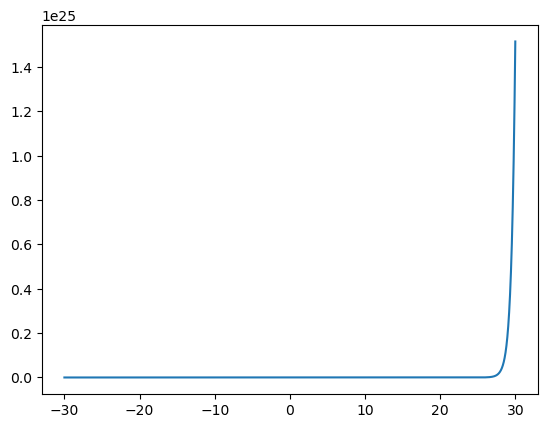

In [5]:
x = np.arange(-30, 30, 0.01)

plt.plot(
        x,
        norm(loc=2, scale=1).pdf(x)/norm(loc=0, scale=1).pdf(x),
    )

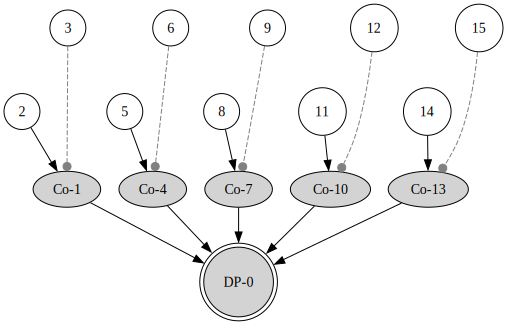

In [12]:
dirichlet_hgf.plot_network()

In [13]:
dirichlet_hgf.attributes[0]

{'n': [1, 1, 7, 1, 0],
 'n_total': 10,
 'n_clusters': 4,
 'alpha': 0.5,
 'value_coupling_parents': (1.0, 1.0, 1.0, 1.0, 1.0)}

## Using a Dirichlet process node

A Dirichlet node has the following parameters:
- $\sigma_\xi$, the default cluster precision.
- $\alpha$, the concentration parameter.
- $\pi_i = \frac{n_i}{\alpha + k - 1}$
- $k$ the current number of clusters
- $n_i$ the number of observations in cluster $C_i$

A Dirichlet process over a measurable set $S$ is specifided by a base distribution $H$ and a concentration parameter $\alpha$. In pyhgf, the base distribution is a tree probabilistic neural network that can operate over $S$. When a new set is observed, the Dirichlet node will chose between the following alternatives:

1. Create a new cluster $C_n$ with probability:
    - $\frac{\alpha}{\alpha + n - 1}p(x|\mu_n, \sigma_n)$
    - with $\mu_n = x$ and $\sigma_n = \sigma_\xi$
2. Merge two cluster $j$ and $k$ into a new cluster $l$ if:
    - $p(x|\mu_l, \sigma_l)\pi_l < p(x|\mu_k, \sigma_k)\pi_k + p(x|\mu_j, \sigma_j)\pi_j$
    - $\mu_l = \frac{\mu_j + \mu_k}{2}$
    - $\sigma_l = \frac{\sigma_j + \sigma_k}{2}$
    - $\pi_l = \frac{n_j + n_k}{\alpha + k - 1}$
3. Otherwise, sample from cluster $C_i$ where:
    - $p(x|\mu_i, \sigma_i)\pi_i \le p(x|\mu_j, \sigma_j)\pi_j \forall j \in C $.

First we start by defining the base distribution $H$. This requires use to detail how the node can create a new distribution, and how to update this distribution. Those steps are declared in the function `base_distribution` and the variable `cluster_updates` (respectively).

fig, ax = plt.subplots();
def update(frame):
    ax.cla()
    sns.histplot(x=input_data[:frame], alpha=.2, bins=40, ax=ax);
    ax.scatter(input_data[frame], -.5, alpha=.5)

animation = FuncAnimation(fig, update, frames=range(len(input_data)), interval=100)
display(HTML(animation.to_jshtml()))